<a href="https://colab.research.google.com/github/Quantamann/DeepLearningForDefectDetectionInSteel-/blob/main/Production_related_error_in_steel_dectection_implementing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files
%matplotlib inline

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
defect_class_mask_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/train.csv')

In [7]:
all_images_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/defect_and_no_defect.csv')

In [10]:
defect_class_mask_df['mask']=defect_class_mask_df['ClassId'].map(lambda x:1)

In [ ]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


Text(0.5, 1.0, 'Number of images per class')

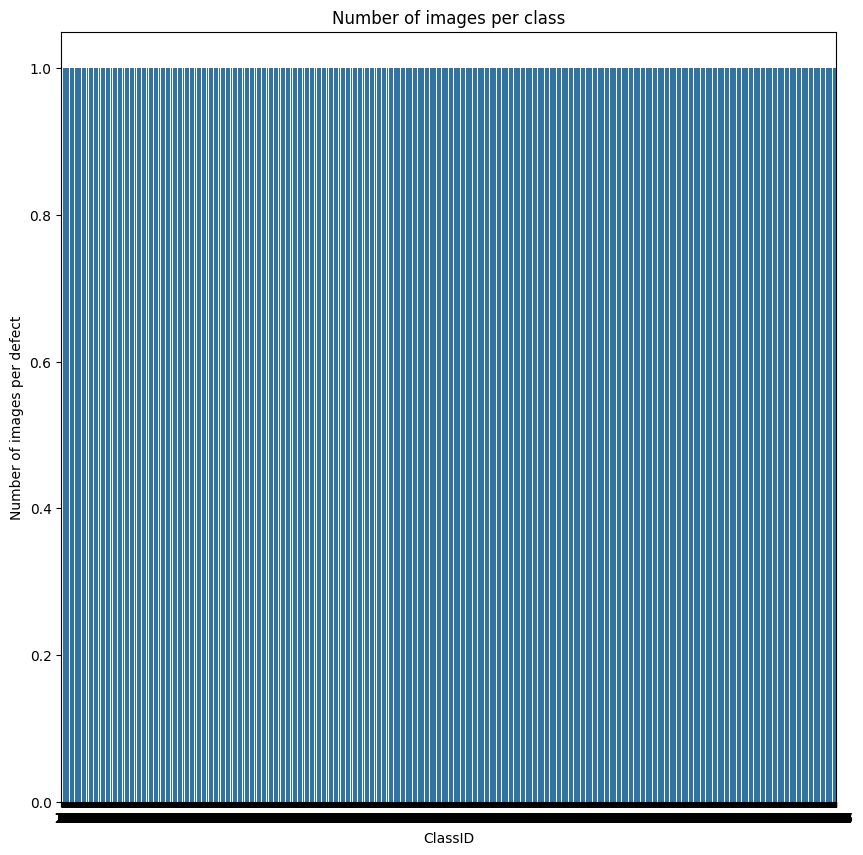

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [12]:
defect_class_mask_df['ClassId'].dtype

dtype('int64')

In [13]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [14]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [15]:
defect_type

,mask
ImageId,
0002cc93b.jpg,1
0007a71bf.jpg,1
000a4bcdd.jpg,1
000f6bf48.jpg,1
0014fce06.jpg,1
...,...
ffcf72ecf.jpg,1
fff02e9c5.jpg,1
fffe98443.jpg,1


Text(0.5, 1.0, 'Number of defects in image')

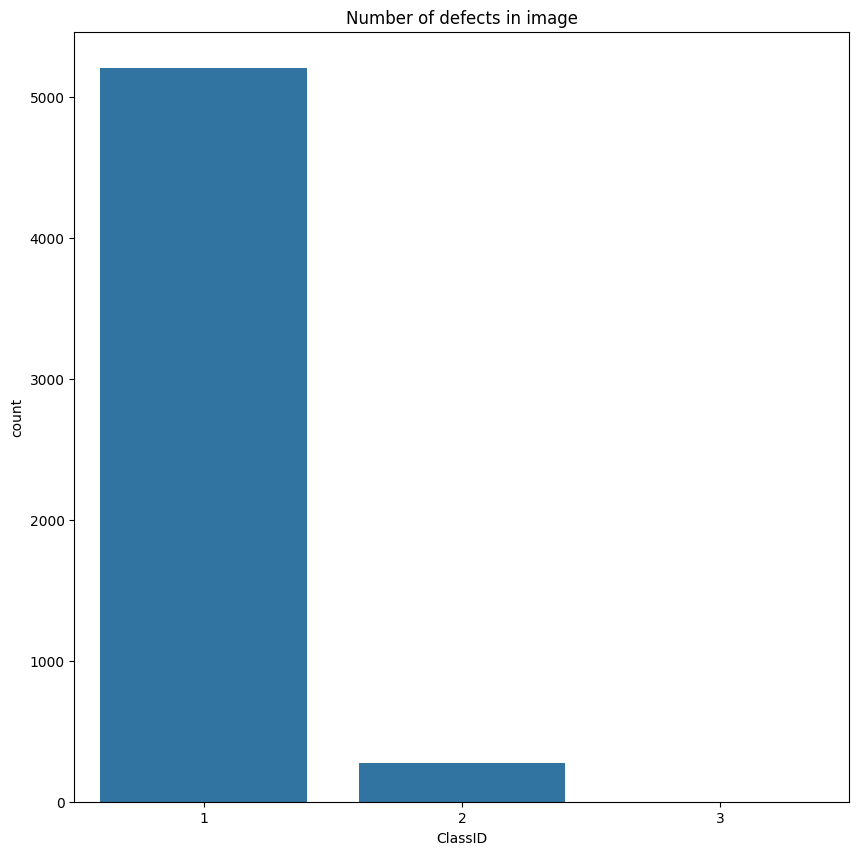

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [17]:
all_images_df.label.value_counts()

,count
label,
1,7095
0,5902


Text(0.5, 1.0, 'Defect and non-defect images')

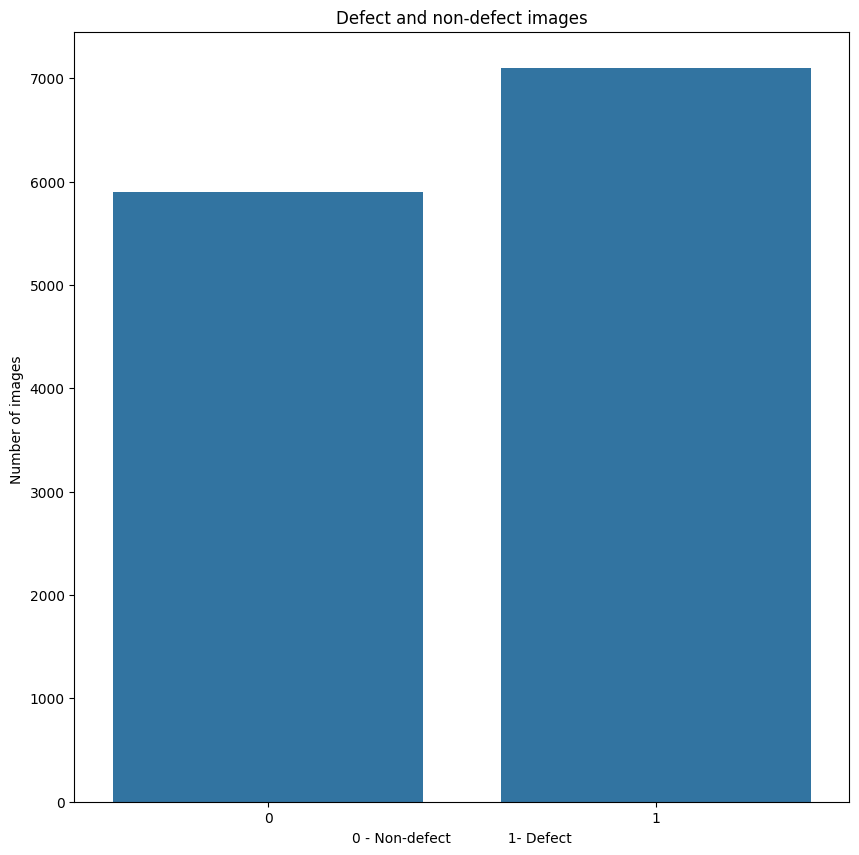

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

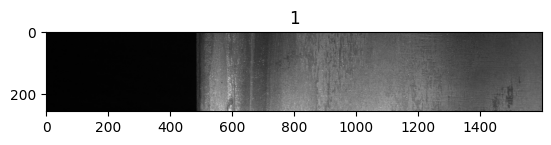

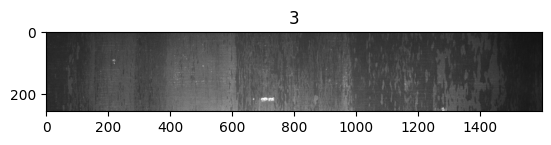

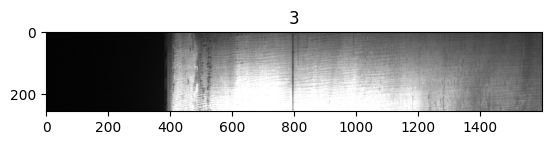

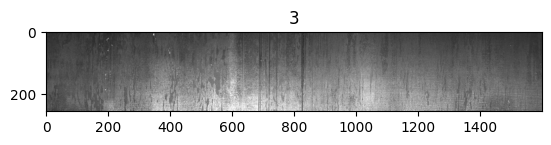

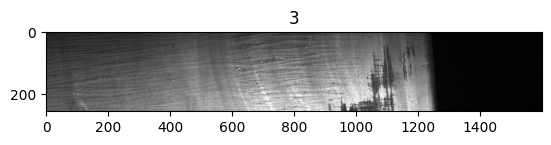

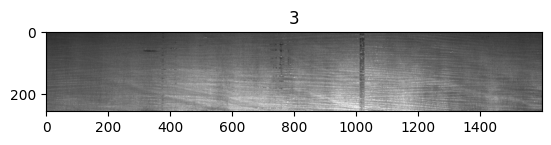

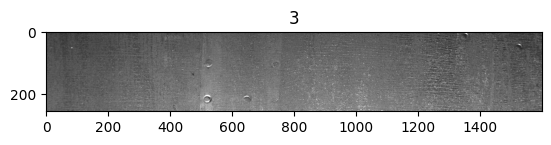

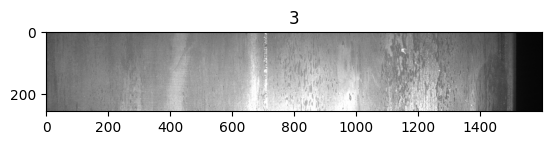

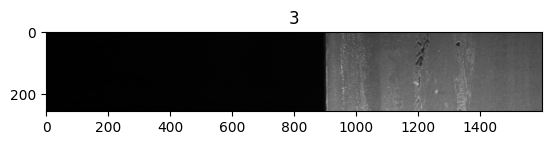

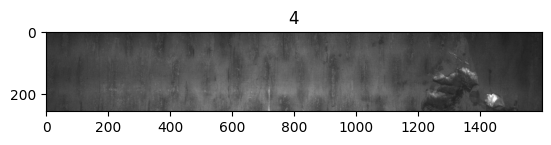

In [151]:
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/train_images/'

for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)


In [20]:
%cd /content/drive/My Drive/Colab Notebooks/6. Maintenance Department
from utilities import rle2mask , mask2rle

train_dir = '/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/train_images/'

/content/drive/My Drive/Colab Notebooks/6. Maintenance Department


In [21]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [22]:
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

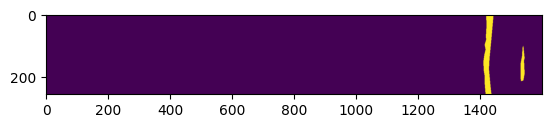

In [23]:
plt.imshow(mask)

(256, 1600, 3)

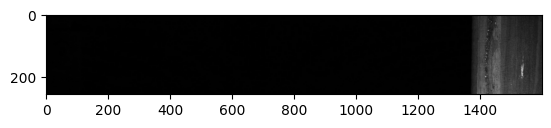

In [24]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

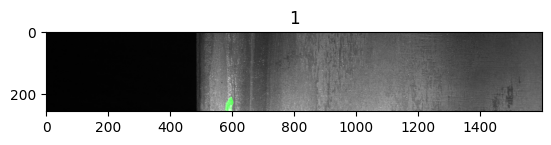

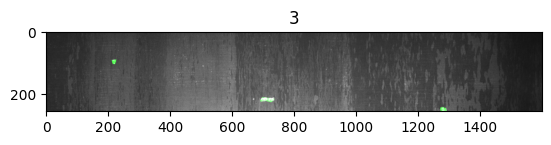

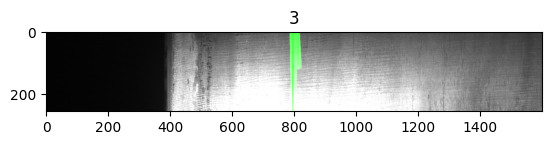

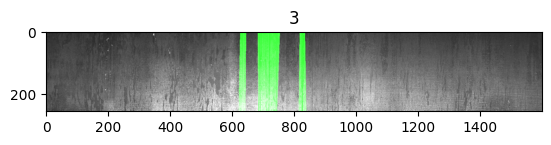

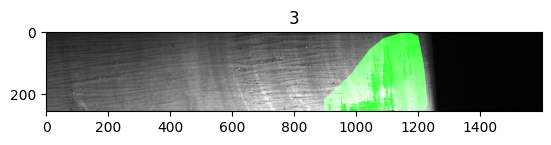

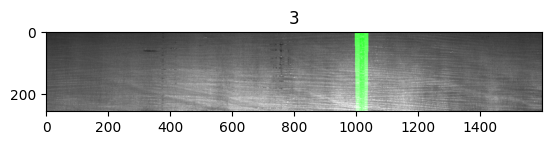

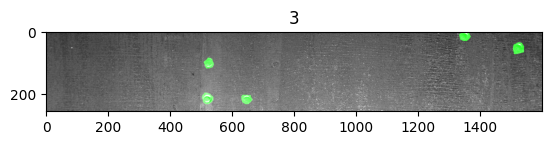

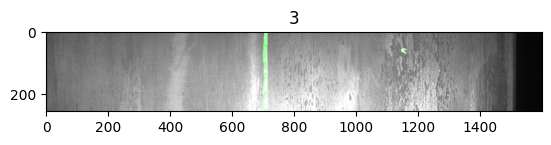

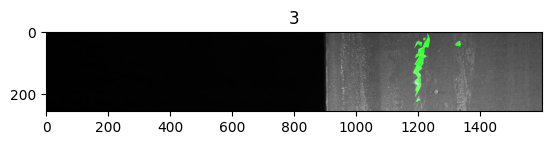

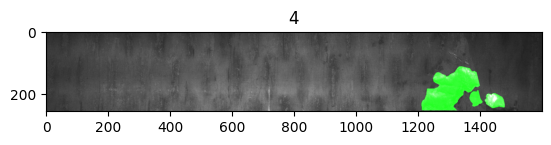

In [25]:
for i in range(10):


  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

In [26]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [28]:
train.shape

(11047, 2)

In [29]:
test.shape

(1950, 2)

In [30]:
train_dir = '/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/train_images/'

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)

train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='ImageID',
    y_col='label',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='other',
    target_size=(256,256))

validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='ImageID',
    y_col='label',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_mode='other',
    target_size=(256,256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [32]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))


Found 1950 validated image filenames.


In [33]:
basemodel=ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [34]:
for layer in basemodel.layers:
  layers.trainable=False

In [35]:
headmodel=basemodel.output
headmodel=AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel=Flatten(name='flatten')(headmodel)
headmodel=Dense(256,activation='relu')(headmodel)
headmodel=Dropout(0.3)(headmodel)
headmodel=Dense(1,activation='sigmoid')(headmodel)

model=Model(inputs=basemodel.input,outputs=headmodel)

In [36]:
model. compile(loss='binary_crossentropy',optimizer='Nadam',metrics=['accuracy'])

In [37]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpointer = ModelCheckpoint(filepath="resnet-weights.keras", verbose=1, save_best_only=True)

In [ ]:
# (WARNING TAKES LONG TIME (~90 mins)!)
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= validation_generator, validation_steps= validation_generator.n //16 , callbacks=[checkpointer,earlystopping])

Epoch 1/40
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8090 - loss: 0.4245 
Epoch 1: val_loss improved from inf to 0.78880, saving model to resnet-weights.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 9799s 17s/step - accuracy: 0.8090 - loss: 0.4245 - val_accuracy: 0.5856 - val_loss: 0.7888
Epoch 2/40
  1/586 ━━━━━━━━━━━━━━━━━━━━ 2:52:14 18s/step - accuracy: 0.8750 - loss: 0.4309
Epoch 2: val_loss improved from 0.78880 to 0.76302, saving model to resnet-weights.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 444s 728ms/step - accuracy: 0.8750 - loss: 0.4309 - val_accuracy: 0.6165 - val_loss: 0.7630
Epoch 3/40
493/586 ━━━━━━━━━━━━━━━━━━━━ 24:26 16s/step - accuracy: 0.8379 - loss: 0.3663

In [38]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/resnet-weights.keras')

In [49]:
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Model(tf.keras.Model):
    pass



with open('/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()


model = tf.keras.models.model_from_json(json_savedModel, custom_objects={'Model': Model}) # Providing the Model class as a custom object.
model.load_weights('/content/drive/My Drive/Colab Notebooks/6. Maintenance Department/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
1+1

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step


In [51]:
test_predict

array([[9.8966444e-01],
       [1.3015592e-01],
       [9.3411373e-08],
       ...,
       [9.9726540e-01],
       [9.2768234e-05],
       [1.0000000e+00]], dtype=float32)

In [52]:
predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [53]:
original = np.asarray(test.label)[:1936]
len(original)

1936

In [54]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(original,predict)
accuracy

0.8713842975206612

<Axes: >

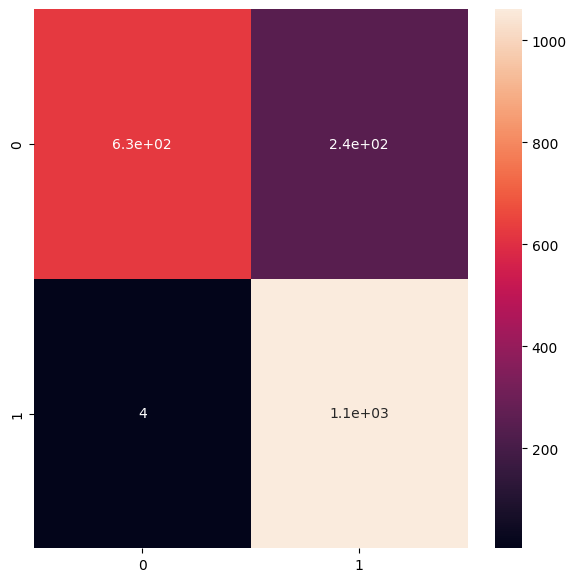

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [56]:
from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       871
           1       0.81      1.00      0.89      1065

    accuracy                           0.87      1936
   macro avg       0.90      0.86      0.86      1936
weighted avg       0.89      0.87      0.87      1936



In [91]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [92]:

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [108]:
from utilities import DataGenerator
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)

In [110]:
def resblock(X, f):



  X_copy = X


  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)


  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)


  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [96]:

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [111]:
input_shape = (256,256,1)


X_input = Input(input_shape)


conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)


conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)


conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)


conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)


up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)


up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)


up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)


up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)


output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [153]:
%cd /content/drive/My Drive/Colab Notebooks/6. Maintenance Department

from utilities import focal_tversky, tversky_loss, tversky

/content/drive/My Drive/Colab Notebooks/6. Maintenance Department


In [154]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [155]:

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.keras", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

In [143]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Model(tf.keras.Model):
    pass

from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel, custom_objects={'Model': CustomResUnet})
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [144]:
test_df = pd.read_csv('test.csv')

In [146]:
from utilities import prediction


image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [147]:
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


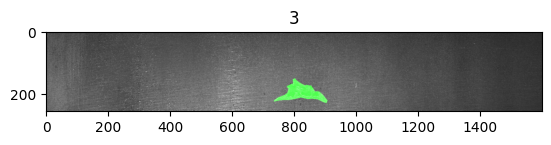

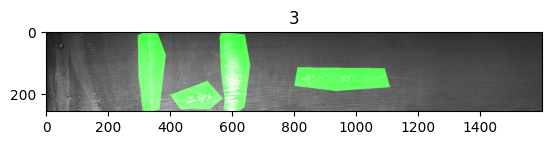

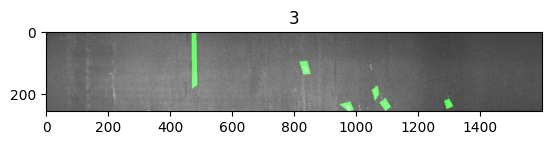

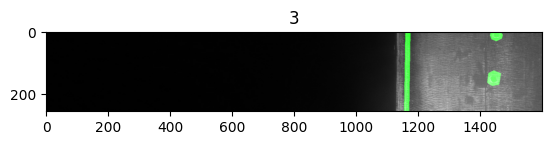

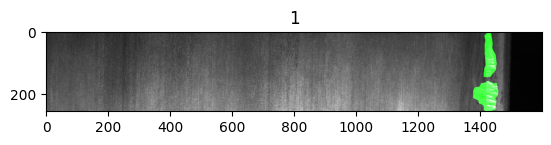

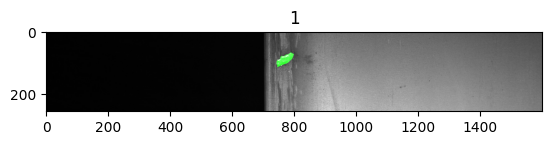

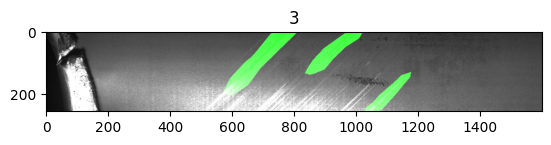

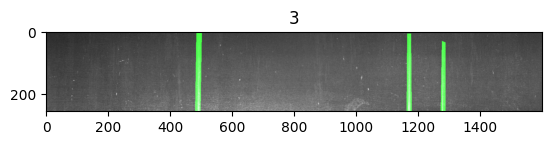

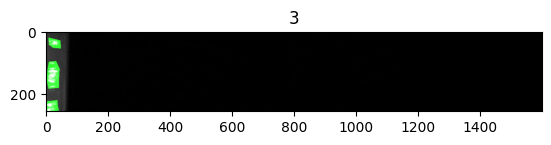

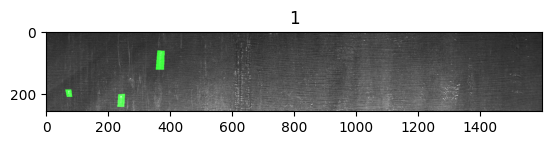

In [152]:
for i in range(10):


  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

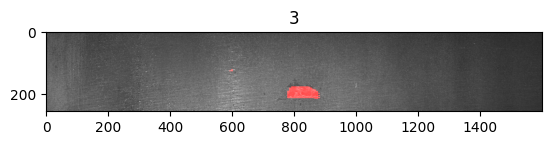

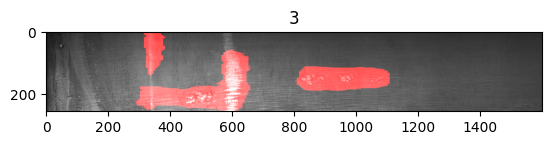

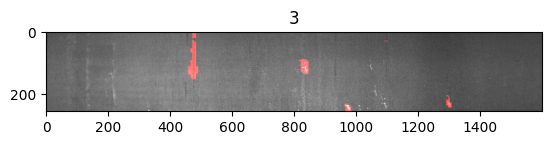

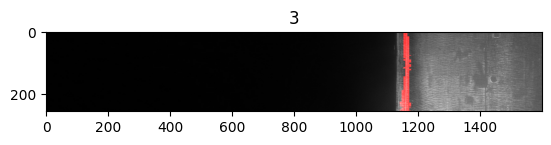

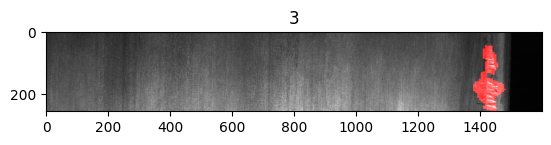

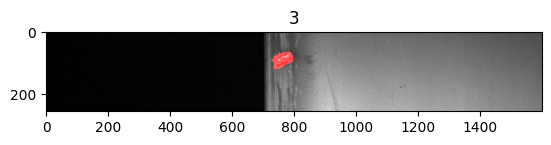

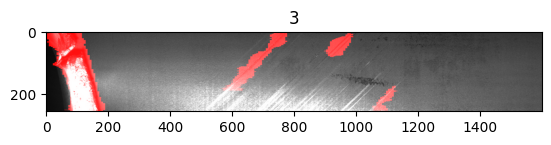

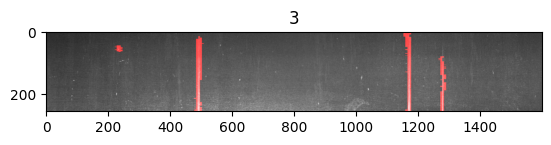

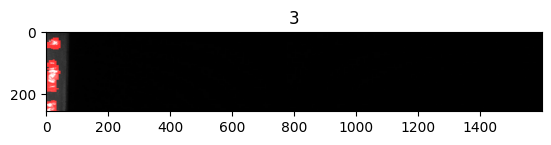

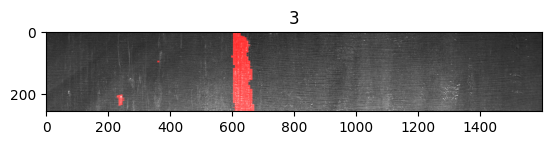

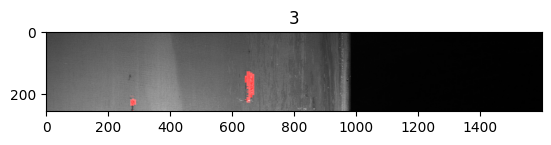

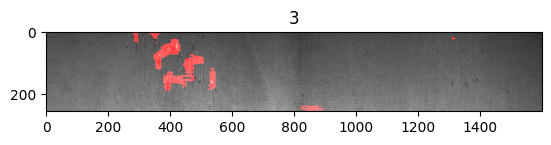

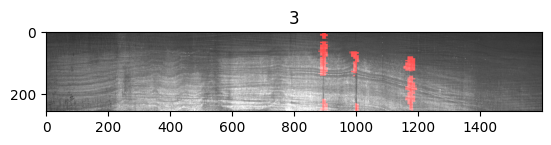

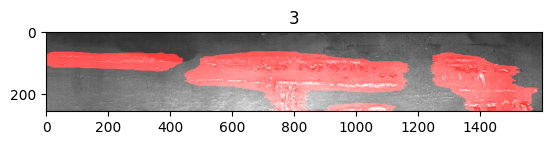

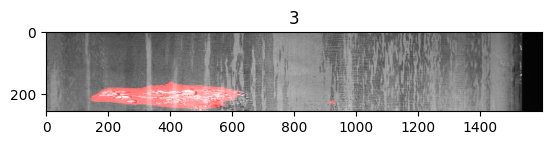

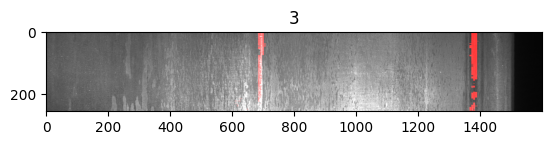

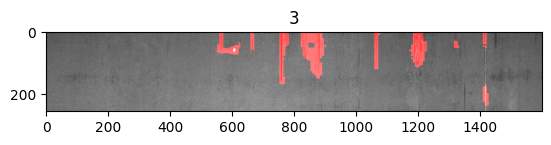

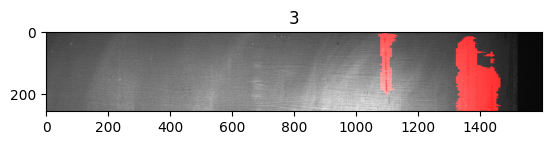

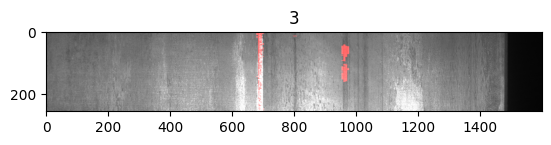

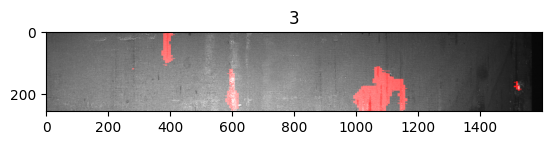

In [150]:
directory = "train_images"

for i in range(20):


  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)